# Week 2_Assignment
## Team members:
- Marc Pérez Quintana  <br>
- Basem Elbarashy <br>
- Sergi Garcia Bordils <br>


## Notes:
- We list/explain at the start of each section the defined variables that will be used in the other sections 
- We assume that you have the following in the current dir:  test/, train/ , test_images_filenames.dat , train_images_filenames.dat, test_labels.dat, train_labels.dat
- The code is tested with python 3 and opencv 3.4


In [69]:
import cv2
import numpy as np
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import svm


## 1) Read the train and test files
- train_images_filenames
- test_images_filenames
- train_labels
- test_labels

- Trainset Size =  1881
- Trainset classes count :  {'Opencountry': 292, 'coast': 244, 'forest': 227, 'highway': 184, 'inside_city': 214, 'mountain': 260, 'street': 212, 'tallbuilding': 248}
- Testset Size =  807
- Testset classes count:  {'Opencountry': 118, 'coast': 116, 'forest': 101, 'highway': 76, 'inside_city': 94, 'mountain': 114, 'street': 80, 'tallbuilding': 108}


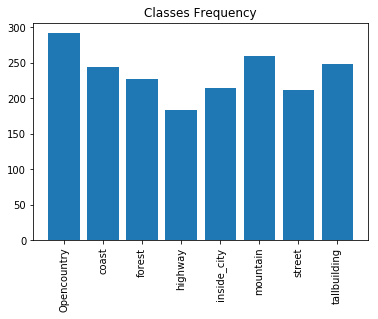

In [74]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

class_count_test = {}
for label in test_labels:
    if label in class_count_test:
        class_count_test[label] += 1
    else: 
        class_count_test[label] = 1
        
class_count_train = {}
for label in train_labels:
    if label in class_count_train:
        class_count_train[label] += 1
    else: 
        class_count_train[label] = 1

print('- Trainset Size = ', len(train_labels))
print("- Trainset classes count : ", class_count_train)
print('- Testset Size = ', len(test_labels))
print("- Testset classes count: ", class_count_test)

plt.bar(range(len(class_count_train)), list(class_count_train.values()), align='center')
plt.xticks(range(len(class_count_train)), list(class_count_train.keys()), rotation='vertical')
plt.title('Classes Frequency')
plt.show()

In [76]:
"""
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
skf_split = skf.split(train_images_filenames, train_labels)

for train_index, validation_index in skf_split:
    print("length of validation_index", len(validation_index))
    print("VALIDATION:", validation_index)
    class_count = {}
    for index in validation_index:
        label = train_labels[index]
        if label in class_count:
            class_count[label] += 1
        else: 
            class_count[label] = 1
    print(class_count)
    print("-------------------------")
"""

'\nskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)\nskf_split = skf.split(train_images_filenames, train_labels)\n\nfor train_index, validation_index in skf_split:\n    print("length of validation_index", len(validation_index))\n    print("VALIDATION:", validation_index)\n    class_count = {}\n    for index in validation_index:\n        label = train_labels[index]\n        if label in class_count:\n            class_count[label] += 1\n        else: \n            class_count[label] = 1\n    print(class_count)\n    print("-------------------------")\n'

## Set the parameters of the execution

In [4]:
num_features = 400 #number of features for the SIFT detector but for densesift it depends on step value
step = 10
k = 300 # codebook size / number of clusters for KMeans / number of words
num_neighbors = 5 #number of neighbors (k) for the k-nn classifier
knn_metric = 'manhattan'#distance for the k-nn classifier
denseSift = True #True if Dense SIFT is to be used, False for classical SIFT
pyramidDepth = 2 # 0-> No spatial pyramid, 1-> whole image + 4 subimages, 2-> lower levels + 16 subimages, ...

## Implementing Dense SIFT
- compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [5]:
def denseSIFT(images_filenames, labels):
    SIFTdetector = cv2.xfeatures2d.SIFT_create(num_features) # Create a SIFT object detector and descriptor
    descriptors = []
    label_per_descriptor = []
    kpts = []

    for filename, labels in zip(images_filenames, labels):
        filename = filename.replace("../../Databases/MIT_split", ".")
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

        if denseSift:
            height, width = gray.shape
            kpt = [cv2.KeyPoint(x, y, step) for y in range(0, gray.shape[0], step) 
                                            for x in range(0, gray.shape[1], step)]
            _, des = SIFTdetector.compute(gray, kpt)

        else:
            kpt, des = SIFTdetector.detectAndCompute(gray, None)

        kpts.append(kpt)
        descriptors.append(des)
        label_per_descriptor.append(labels)

    return (kpts, descriptors, np.vstack(descriptors))

Train_kpts, Train_descriptors, D = denseSIFT(train_images_filenames, train_labels)

## Compute k-means clustering on the descriptor space

In [6]:
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=6000, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=300, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

### For each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [7]:
def get_visual_words(descriptors, kpts):
    for level in range(pyramidDepth+1):
        if(level == 0):
            pyramid_visual_words = np.zeros((len(descriptors), k), dtype=np.float32)
            for i in range(len(descriptors)):
                for word in codebook.predict(descriptors[i]):   
                    pyramid_visual_words[i,word]+=1
        else:
            for x in range(2**level):
                    for y in range(2**level): 
                        visual_words=np.zeros((len(descriptors),k),dtype=np.float32)
                        for i in range(len(descriptors)):    
                            words = codebook.predict(descriptors[i])
                            for keypoint in range(len(descriptors[i])):
                                x_pt, y_pt = kpts[i][keypoint].pt
                                if (x_pt>=x*256/(2**level) and x_pt<(x+1)*256/(2**level) and y_pt>=x*256/(2**level) and y_pt<(x+1)*256/(2**level)):
                                    visual_words[i, words[keypoint]]+=1
                        pyramid_visual_words = np.append(pyramid_visual_words, visual_words, axis=1)
        #print(pyramid_visual_words.shape)
    return pyramid_visual_words
visual_words = get_visual_words(Train_descriptors, Train_kpts)

## Build a k-nn classifier and train it with the train descriptors

In [8]:
knn = KNeighborsClassifier(n_neighbors=num_neighbors,n_jobs=-1,metric=knn_metric)
knn.fit(visual_words, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

## Compute the test descriptors and compute the accuracy of the model

In [9]:
Test_kpts, Test_descriptors, D = denseSIFT(test_images_filenames, test_labels)
visual_words_test = get_visual_words(Test_descriptors, Test_kpts)


In [10]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

78.56257744733581


In [11]:
visual_words.shape

(1881, 6300)

In [26]:
clf = svm.SVC(kernel='rbf', C = 1.5, gamma='auto')
clf.fit(visual_words, train_labels)
accuracy = 100*clf.score(visual_words_test, test_labels)
print(accuracy)


77.19950433705081


In [36]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(alpha=.0001, n_iter=60, penalty='l2', shuffle=True, random_state=0,verbose=0)
clf.fit(visual_words, train_labels)
accuracy = 100*clf.score(visual_words_test, test_labels)
print(accuracy)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


82.40396530359355


## Create 5 Stratified Folds for Cross-validation

In [13]:
def evaluate_model():
    validation_split_num = 1
    accuracys = []
    skf_split = skf.split(train_images_filenames, train_labels)
    for train_index, validation_index in skf_split:
        print(validation_split_num)
        cv_train_images_filenames = []
        cv_train_labels = []
        validation_images_filenames = []
        validation_labels = []
        for index in train_index:
            cv_train_images_filenames.append(train_images_filenames[index])
            cv_train_labels.append(train_labels[index])                
        for index in validation_index:
            validation_images_filenames.append(train_images_filenames[index])
            validation_labels.append(train_labels[index]) 

        cv_Train_kpts, cv_Train_descriptors, D = denseSIFT(cv_train_images_filenames, cv_train_labels)
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        codebook.fit(D)
        visual_words = get_visual_words(cv_Train_descriptors, cv_Train_kpts)
        
        knn = KNeighborsClassifier(n_neighbors=num_neighbors,n_jobs=-1,metric=knn_metric)
        knn.fit(visual_words, cv_train_labels)
        
        
        Validation_kpts, Validation_descriptors, D = denseSIFT(validation_images_filenames, validation_labels)
        visual_words_validation = get_visual_words(Validation_descriptors, Validation_kpts)
        
        accuracy = 100*knn.score(visual_words_validation, validation_labels)
        accuracys.append(accuracy)

        with open('parameters_execution.log', 'a') as f:
            f.write('denseSift: '+str(denseSift)+', '+
                    'num_features: '+str(num_features)+', '+
                    'k: '+str(k)+', '+
                    'num_neighbors: '+str(num_neighbors)+', '+
                    'knn_metric: '+str(knn_metric)+', '+
                    'step: '+str(step)+', '+
                    'pyramidDepth: '+str(pyramidDepth)+', '+
                    'validation_split_num: '+str(validation_split_num)+', '+
                    'accuracy: '+str(accuracy)+'\n')
        validation_split_num += 1
    return accuracys

In [14]:
"""
dict_k = {}
for k in range(100,2001,100): #parameter to be optimized by cv and range 
    print(k)
    acc = evaluate_model()
    dict_k[k] = acc
print(dict_k)
""" 
    

'\ndict_k = {}\nfor k in range(100,2001,100): #parameter to be optimized by cv and range \n    print(k)\n    acc = evaluate_model()\n    dict_k[k] = acc\nprint(dict_k)\n'

## We tuned parameters individually first and then tuned all at the same time
### Visualizing how each parameter affect the accuracy after trying several values for each one

In [15]:
import numpy as np
import matplotlib.pyplot as plt


k_range             = np.arange(20, 600, 20)
num_neighbors_range = np.arange(1, 18, 1)
step_range          = np.arange(10,40,5)
knn_metric_range    = ['Chebyshev','Euclidean','Manhattan']

k_acc               = [66.5,73.2,70.7,75.9,73.3,76.2,76.3,73.4,74.5,75.2,75.2,74.9,76.3,73.9,75.2,75.9,76.7,77.5,74.2,73.6,74.5,76.7,76.4,74.2,72.9,74.5,76.0, 75.9, 72.7]
num_neighbors_acc   = [70.6,71.1,73.6,76.2,77.5,75.9,75.8,75.8,75.8,76.8,77.3,77.6,77.4,77.6,76.7,75.9, 76.5]
step_acc            = [77.5, 74.3, 75.9, 75.7, 74.4, 73.3]
knn_metric_acc      = [59.60,77.57, 78.31]

plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.plot(k_range, k_acc, 'r--');  plt.plot(k_range, k_acc, 'o');  
plt.xlabel('K');  plt.ylabel('Accuracy');

plt.subplot(222)
plt.plot(num_neighbors_range, num_neighbors_acc, 'r--');  plt.plot(num_neighbors_range, num_neighbors_acc, 'o');  
plt.xlabel('Num_neighbors');  plt.ylabel('Accuracy');


plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.plot(step_range, step_acc, 'r--');  plt.plot(step_range, step_acc, 'o');  
plt.xlabel('Step');  plt.ylabel('Accuracy');


plt.subplot(222)
plt.plot(knn_metric_range, knn_metric_acc, 'r--');  plt.plot(knn_metric_range, knn_metric_acc, 'o');  
plt.xlabel('Knn_metric');  plt.ylabel('Accuracy');

### Tuning all parameters at the same time, visualizing the accuracy versus different configurations of parameters 


    
| denseSift | num_features   | k | num_neighbors | knn_metric | step | accuracy |
|------|------|------|------|------|------|------|
|   True  | 676 | 100  | 5 | manhattan  | 10 | 77.3  | 
|   True  | 676 | 100  | 5 | euclidean  | 10 | 73.3  | 
|   True  | 169 | 100  | 5 | manhattan  | 20 | 74.3  | 
|   True  | 169 | 100  | 5 | euclidean  | 20 | 74.3  | 
|   True  | 676 | 100  | 10 | manhattan  | 10 | 77.6  | 
|   True  | 676 | 100  | 10 | euclidean  | 10 | 74.9  | 
|   True  | 169 | 100  | 10 | manhattan  | 20 | 75.4  | 
|   True  | 169 | 100  | 10 | euclidean  | 20 | 74.5  | 
|   True  | 676 | 300  | 5 | manhattan  | 10 | 80.9  | 
|   True  | 676 | 300  | 5 | euclidean  | 10 | 75.2  | 
|   True  | 169 | 300  | 5 | manhattan  | 20 | 77.1  | 
|   True  | 169 | 300  | 5 | euclidean  | 20 | 75.9  | 
|   True  | 676 | 300  | 10 | manhattan  | 10 | 80.5  | 
|   True  | 676 | 300  | 10 | euclidean  | 10 | 75.3  | 
|   True  | 169 | 300  | 10 | manhattan  | 20 | 77.1  | 
|   True  | 169 | 300  | 10 | euclidean  | 20 | 76.4  | 
|   True  | 2704 | 300  | 10 | manhattan  | 5 | 80.7  | 
|   False  | 500 | 300  | 5 | manhattan  | - | 48.3  | 
|   False  | 800 | 300  | 5 | manhattan  | - | 52  | 



## Conclusion 
- We found that the dataset is balanced and no need for using class_weight for loss claculation while training or any any other solutions